In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from sklearn.linear_model import LinearRegression
import theano.tensor as T

/home/user/ml/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### ex 6.2

In [2]:
df = pd.DataFrame({
    'year': list(range(1976, 1986)),
    'fatal_accidents': [24, 25, 31, 31, 22, 21, 26, 20, 16, 22],
    'passenger_deaths': [734, 516, 754, 877, 814, 362, 764, 809, 223, 1066],
    'death_rate': [0.19, 0.12, 0.15, 0.16, 0.14, 0.06, 0.13, 0.13, 0.03, 0.15]
})

In [3]:
df

,death_rate,fatal_accidents,passenger_deaths,year
0,0.19,24,734,1976
1,0.12,25,516,1977
2,0.15,31,754,1978
3,0.16,31,877,1979
4,0.14,22,814,1980
5,0.06,21,362,1981
6,0.13,26,764,1982
7,0.13,20,809,1983
8,0.03,16,223,1984
9,0.15,22,1066,1985


In [4]:
df['passenger_miles_flows'] = 100 * 10 ** 6 * df['passenger_deaths'].values / df['death_rate'].values

In [5]:
df

,death_rate,fatal_accidents,passenger_deaths,year,passenger_miles_flows
0,0.19,24,734,1976,3.863158e+11
1,0.12,25,516,1977,4.300000e+11
2,0.15,31,754,1978,5.026667e+11
3,0.16,31,877,1979,5.481250e+11
4,0.14,22,814,1980,5.814286e+11
5,0.06,21,362,1981,6.033333e+11
6,0.13,26,764,1982,5.876923e+11
7,0.13,20,809,1983,6.223077e+11
8,0.03,16,223,1984,7.433333e+11
9,0.15,22,1066,1985,7.106667e+11


In [6]:
with pm.Model() as model1:
    theta = pm.Gamma('theta', mu=25, sd=10)
    y = pm.Poisson('y', mu=theta, observed=df['fatal_accidents'].values)
    trace1 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 5428.62draws/s]


In [7]:
mu = 10 ** (-10)
sd = 10 ** (-8)
with pm.Model() as model2:
    theta = pm.Gamma('theta', mu=mu, sd=sd)
    ratio = theta * df['passenger_miles_flows'].values
    y = pm.Poisson('y', mu=ratio, observed=df['fatal_accidents'].values)
    trace2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 5035.38draws/s]


In [8]:
with pm.Model() as model3:
    theta = pm.Gamma('theta', mu=500, sd=100)
    y = pm.Poisson('y', mu=theta, observed=df['passenger_deaths'].values)
    trace3 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4770.99draws/s]
The acceptance probability does not match the target. It is 0.8858692008963709, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8936167507611946, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8938056668972537, but should be close to 0.8. Try to increase the number of tuning steps.


In [9]:
mu = 10 ** (-11)
sd = 10 ** (-9)
with pm.Model() as model4:
    theta = pm.Gamma('theta', mu=mu, sd=sd)
    ratio = theta * df['passenger_miles_flows'].values
    y = pm.Poisson('y', mu=ratio, observed=df['passenger_deaths'].values)
    trace4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:01<00:00, 4845.41draws/s]


For each the models, set up posterior predictive test quantities to check the following assumptions 
- independent Poisson distributions 
- no trend over time 

In [10]:
# First two models 
ppc1 = pm.sample_posterior_predictive(trace1, samples=1000, model=model1)
ppc2 = pm.sample_posterior_predictive(trace2, samples=1000, model=model2)

100%|██████████| 1000/1000 [00:00<00:00, 2539.50it/s]


In [11]:
ppc1.keys()

dict_keys(['y'])

In [12]:
ppc1 = ppc1['y']
ppc2 = ppc2['y']

In [13]:
ppc1.shape, ppc2.shape

((1000, 10), (1000, 10))

In [14]:
# for simplicity y_{t} = a * y_{t-1} + b
def compute_a(x):
    lm = LinearRegression()
    lm.fit(x[:-1].reshape((-1, 1)), x[1:])
    return lm.coef_[0]

In [15]:
# first model 
ts1 = []
for i in range(1000):
    ts1.append(
        compute_a(ppc1[i])
    )
# second model
ts2 = []
for i in range(1000):
    ts2.append(
        compute_a(ppc2[i])
    )

In [16]:
T = compute_a(df['fatal_accidents'].values)

In [17]:
T

0.4183673469387755

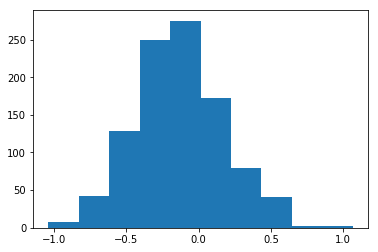

In [18]:
plt.hist(ts1);

In [19]:
# p value for the first model
np.mean(np.array(ts1) > T)

0.052

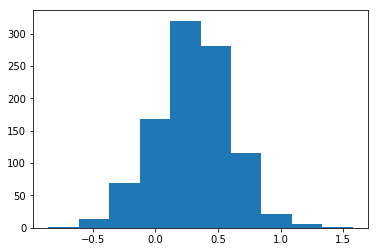

In [20]:
plt.hist(ts2);

In [21]:
# p value for the second model
np.mean(np.array(ts2) > T)

0.356